<a href="https://colab.research.google.com/github/catlaughing/kaggle-house-price/blob/master/Kaggle_Arkav(Cont'd).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

In [0]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import skew
import xgboost as xgb
import lightgbm as lgb

In [3]:
# !pip install seaborn==0.9.0
sns.__version__

'0.9.0'

# Download Data from Kaggle

In [8]:
## Get the dataset Ready ##

# Install Kaggle and make directory for kaggle
!pip install -U -q kaggle && mkdir -p ~/.kaggle

# move json file from kaggle to the kaggle directory
!cp kaggle.json ~/.kaggle/

# Download the dataset
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 29.0MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 57.6MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 61.2MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 11.0MB/s]


# Helper Function

In [0]:
def print_score(m, feat_train, label_train, feat_test, label_test):
  res = [np.sqrt(mse(m.predict(feat_train), label_train)), np.sqrt(mse(m.predict(feat_test), label_test)),
              m.score(feat_train, label_train), m.score(feat_test, label_test)]
  if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
  print(res)

In [0]:
#Validation function
def rmsle_cv(model):
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X, labels, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

# EDA

In [11]:
df_raw = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

print(df_raw.shape)
print(df_test.shape)

(1460, 81)
(1459, 80)


## Outliers and NA's


### Outliers

In [0]:
best_corr = (df_raw[df_raw.columns[1:]].corr()['SalePrice'][:-1]).sort_values(ascending=False)[:10]

In [0]:
use_features = best_corr.keys()

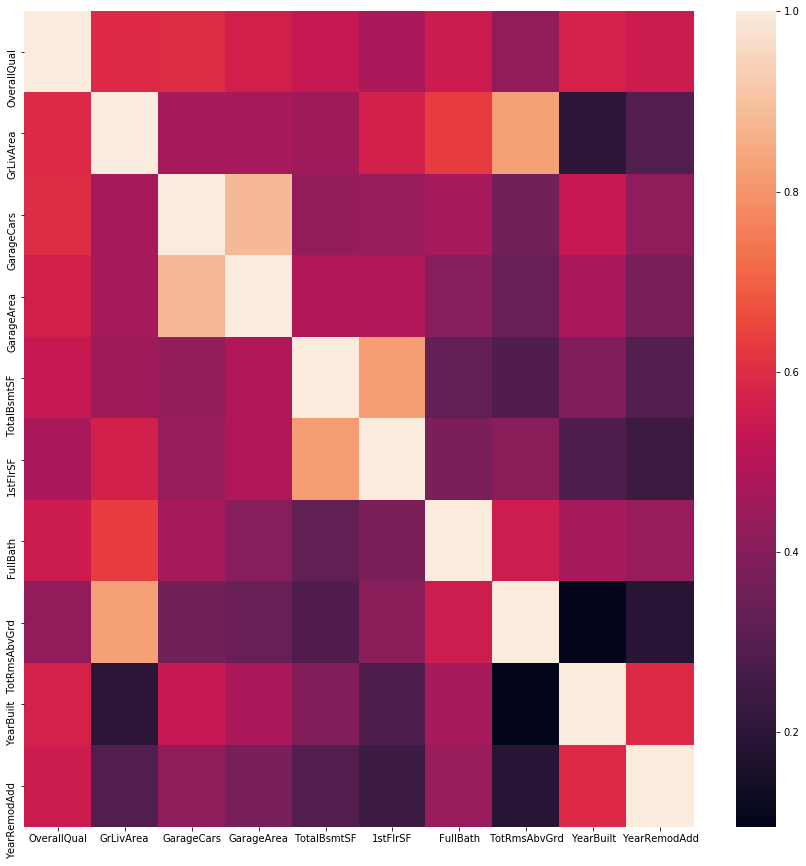

In [14]:
plt.figure(figsize = (15,15))
sns.heatmap(df_raw[use_features].corr());

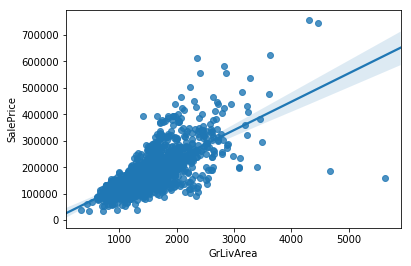

In [15]:
sns.regplot('GrLivArea','SalePrice',data=df_raw)

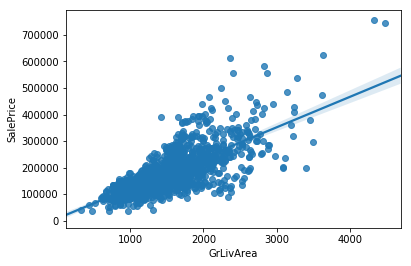

In [16]:
## DROP OUTLIERS ##
df_raw = df_raw[df_raw['GrLivArea']<4500]
sns.regplot('GrLivArea','SalePrice',data=df_raw)

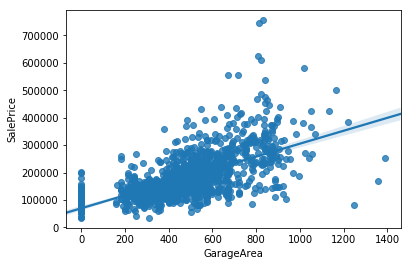

In [17]:
sns.regplot('GarageArea','SalePrice',data=df_raw)

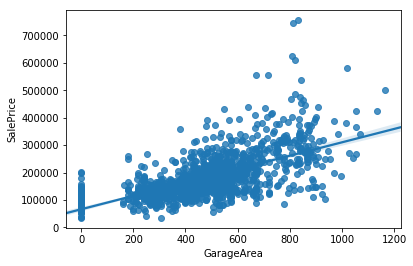

In [18]:
## DROP OUTLIERS ##
df_raw = df_raw[(df_raw['GarageArea']<1200)]
sns.regplot('GarageArea','SalePrice',data=df_raw)

In [0]:
## DROP GarageCars high corr with GarageArea
df_raw.drop('GarageCars',axis=1, inplace=True)

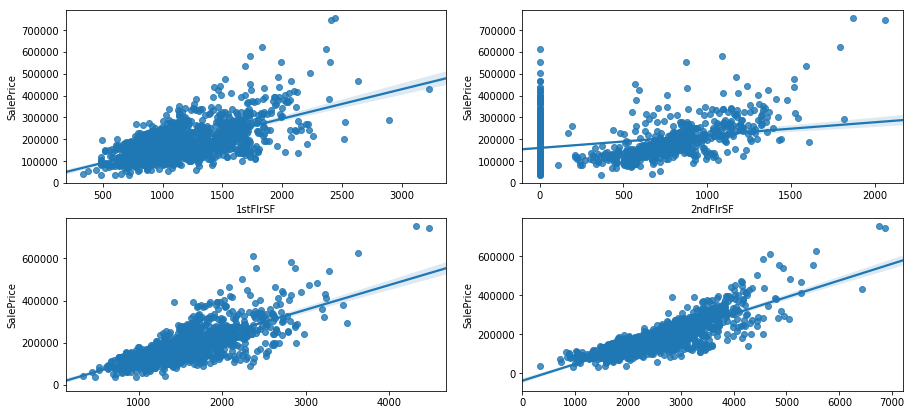

In [20]:
plt.figure(figsize=(15,7))
plt.subplot(221)
sns.regplot('1stFlrSF','SalePrice',data=df_raw);
plt.subplot(222)
sns.regplot('2ndFlrSF','SalePrice',data=df_raw);
plt.subplot(223)
sns.regplot(df_raw['1stFlrSF'] + df_raw['2ndFlrSF'],df_raw['SalePrice'])
plt.subplot(224)
sns.regplot(df_raw['1stFlrSF'] + df_raw['2ndFlrSF']+df_raw['TotalBsmtSF'],df_raw['SalePrice'])



In [21]:
df_raw = df_raw.drop(['Id'], axis=1)
df_test = df_test.drop(['Id'], axis=1)

print(df_raw.shape)
print(df_test.shape)

(1454, 79)
(1459, 79)


In [22]:
df_raw.SalePrice = np.log1p(df_raw.SalePrice)

labels = df_raw['SalePrice'].reset_index(drop=True)

df_raw_feature = df_raw.drop('SalePrice',axis=1)

all_features = pd.concat([df_raw_feature, df_test]).reset_index(drop=True)
print(all_features.shape)

all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

(2913, 79)


In [23]:
all_features.describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,OpenPorchSF,OverallCond,OverallQual,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
count,2913.000000,2913.000000,2913.000000,2913.000000,2912.000000,2912.000000,2911.000000,2911.000000,2912.000000,2913.000000,...,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2912.000000,2913.000000,2913.000000,2913.000000
mean,1157.002060,336.322691,2.607621,2.860625,438.658654,49.684409,0.429062,0.061491,560.275069,23.145898,...,47.291795,5.566426,6.086165,2.091658,16.095434,6.447305,1048.618132,93.542739,1971.279094,1984.246481
std,384.669826,428.232473,25.213828,0.823215,443.583403,169.364911,0.524028,0.245924,438.960256,64.301832,...,67.152749,1.113324,1.403656,34.585013,56.237482,1.565002,428.556170,126.421729,30.284855,20.886591
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1872.000000,1950.000000
25%,876.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,220.000000,0.000000,...,0.000000,5.000000,5.000000,0.000000,0.000000,5.000000,792.750000,0.000000,1953.000000,1965.000000
50%,1082.000000,0.000000,0.000000,3.000000,368.000000,0.000000,0.000000,0.000000,467.000000,0.000000,...,26.000000,5.000000,6.000000,0.000000,0.000000,6.000000,988.000000,0.000000,1973.000000,1993.000000
75%,1383.000000,704.000000,0.000000,3.000000,732.250000,0.000000,1.000000,0.000000,803.250000,0.000000,...,70.000000,6.000000,7.000000,0.000000,0.000000,7.000000,1300.500000,168.000000,2001.000000,2004.000000
max,5095.000000,2065.000000,508.000000,8.000000,4010.000000,1526.000000,3.000000,2.000000,2336.000000,1012.000000,...,742.000000,9.000000,10.000000,800.000000,576.000000,15.000000,5095.000000,1424.000000,2010.000000,2010.000000


In [24]:
all_features.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


### NA's

Text(0.5, 1.0, 'Percent missing data by feature')

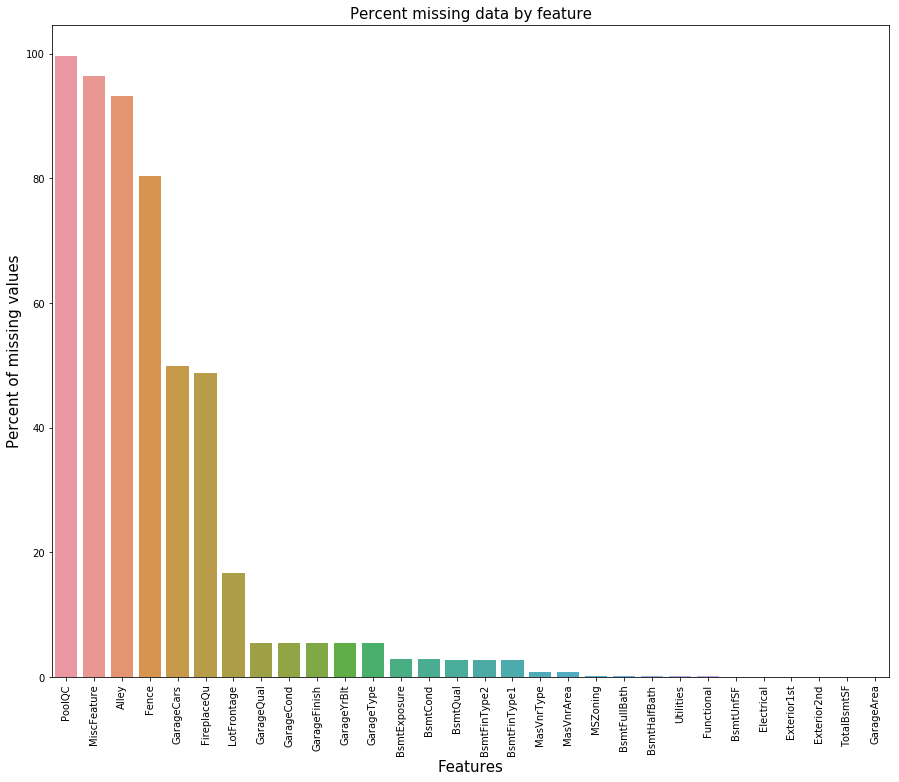

In [25]:
all_data_na = (all_features.isnull().sum() / len(all_features)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [0]:
all_features['Functional'] = all_features['Functional'].fillna('Typ')
all_features['Electrical'] = all_features['Electrical'].fillna("SBrkr")
all_features['KitchenQual'] = all_features['KitchenQual'].fillna("TA")

all_features['Exterior1st'] = all_features['Exterior1st'].fillna(all_features['Exterior1st'].mode()[0])
all_features['Exterior2nd'] = all_features['Exterior2nd'].fillna(all_features['Exterior2nd'].mode()[0])

all_features['SaleType'] = all_features['SaleType'].fillna(all_features['SaleType'].mode()[0])

In [27]:
pd.set_option('max_columns', None)
all_features[all_features['PoolArea'] > 0 & all_features['PoolQC'].isnull()]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
197,1360,1360,0,NaN,4,1Fam,TA,No,1036.0,184.0,GLQ,LwQ,1.0,1.0,TA,140.0,Y,Artery,Norm,SBrkr,552,Gd,Gd,Stucco,Stucco,GdPrv,Ex,1,PConc,2,Typ,795.0,NaN,TA,Unf,TA,Detchd,1918.0,3112,0,GasA,Gd,2Story,1,Gd,Lvl,Gtl,25419,Corner,174.0,Reg,392,75,RL,0.0,None,NaN,0,3,NAmes,16,4,8,Y,512,Ex,CompShg,Gable,Abnorml,WD,0,Pave,8,1360.0,AllPub,0,1918,1990,2006
808,1309,0,0,NaN,3,1Fam,TA,No,663.0,377.0,ALQ,LwQ,1.0,0.0,TA,0.0,Y,Norm,Norm,SBrkr,0,TA,TA,HdBoard,HdBoard,GdPrv,Fa,1,CBlock,1,Typ,484.0,NaN,TA,RFn,TA,Attchd,1974.0,1309,1,GasA,Fa,1Story,1,Gd,Lvl,Gtl,10140,Inside,78.0,Reg,0,20,RL,99.0,BrkFace,NaN,0,1,NWAmes,0,6,6,Y,648,Fa,CompShg,Hip,Normal,WD,0,Pave,5,1040.0,AllPub,265,1974,1999,2006
1166,1118,0,0,NaN,3,1Fam,TA,Av,522.0,0.0,ALQ,Unf,1.0,0.0,TA,574.0,Y,Norm,Norm,SBrkr,0,TA,TA,Plywood,Plywood,GdPrv,Po,1,CBlock,1,Typ,358.0,NaN,TA,Fin,TA,Attchd,1977.0,1118,0,GasA,TA,SLvl,1,TA,Lvl,Gtl,9880,Inside,76.0,Reg,0,80,RL,0.0,None,NaN,0,7,Mitchel,0,6,6,Y,576,Gd,CompShg,Gable,Normal,WD,0,Pave,6,1096.0,AllPub,203,1977,1977,2008
1178,2411,2065,0,NaN,4,1Fam,TA,Av,2096.0,0.0,GLQ,Unf,1.0,0.0,Ex,300.0,Y,Norm,Norm,SBrkr,0,TA,Gd,Wd Sdng,ImStucc,MnPrv,TA,2,PConc,3,Typ,813.0,NaN,TA,Fin,TA,Attchd,1996.0,4476,1,GasA,Ex,2Story,1,Ex,Lvl,Gtl,15623,Corner,160.0,IR1,0,60,RL,0.0,None,NaN,0,7,NoRidge,78,5,10,Y,555,Ex,CompShg,Hip,Abnorml,WD,0,Pave,10,2396.0,AllPub,171,1996,1996,2007
1380,1392,1392,0,NaN,5,1Fam,TA,No,790.0,469.0,BLQ,LwQ,1.0,0.0,Gd,133.0,Y,RRAn,Norm,SBrkr,0,TA,TA,Plywood,Plywood,MnPrv,TA,2,CBlock,3,Typ,564.0,NaN,TA,RFn,TA,Attchd,1978.0,2784,1,GasA,TA,2Story,1,Gd,Lvl,Gtl,16692,Inside,80.0,IR1,0,60,RL,184.0,BrkFace,TenC,2000,7,NWAmes,112,5,7,Y,519,Fa,CompShg,Gable,Normal,WD,440,Pave,12,1392.0,AllPub,0,1978,1978,2006
1417,1575,626,0,NaN,4,1Fam,TA,Av,0.0,0.0,Unf,Unf,0.0,0.0,Gd,697.0,Y,Norm,Norm,SBrkr,0,Gd,Gd,Plywood,Plywood,GdPrv,Gd,1,CBlock,2,Typ,432.0,NaN,Gd,Unf,Gd,Attchd,1966.0,2201,0,GasA,TA,SLvl,1,Gd,Lvl,Gtl,19690,CulDSac,NaN,IR1,0,80,RL,0.0,None,NaN,0,8,Edwards,236,7,6,Y,738,Gd,Tar&Grv,Flat,Alloca,WD,0,Pave,8,697.0,AllPub,586,1966,1966,2006
1968,2470,0,0,NaN,1,1Fam,TA,Gd,2257.0,0.0,GLQ,Unf,2.0,0.0,Ex,278.0,Y,Norm,Norm,SBrkr,0,TA,Ex,MetalSd,MetalSd,NaN,Gd,2,PConc,1,Typ,789.0,3.0,TA,Fin,TA,Attchd,2003.0,2470,1,GasA,Ex,1Story,1,Ex,HLS,Mod,12720,Inside,106.0,Reg,0,20,RL,680.0,Stone,NaN,0,2,NridgHt,65,5,10,Y,144,Ex,CompShg,Hip,Normal,WD,216,Pave,7,2535.0,AllPub,154,2003,2003,2008
2414,1647,0,0,NaN,3,1Fam,TA,No,595.0,354.0,BLQ,Rec,1.0,0.0,TA,156.0,Y,Norm,Norm,SBrkr,0,TA,TA,VinylSd,VinylSd,GdPrv,Fa,1,CBlock,1,Min1,280.0,1.0,TA,Fin,TA,Attchd,1953.0,1647,0,GasA,Gd,1Story,1,TA,Lvl,Gtl,9532,Inside,75.0,Reg,0,20,RL,0.0,None,NaN,0,2,NAmes,0,6,4,Y,368,NaN,CompShg,Gable,Normal,WD,0,Pave,6,1105.0,AllPub,225,1953,1953,2007
2497,1105,717,0,NaN,4,1Fam,TA,No,0.0,0.0,Unf,Unf,0.0,0.0,TA,1105.0,Y,Feedr,Norm,SBrkr,1012,TA,TA,Wd Sdng,Wd Sdng,NaN,Po,1,CBlock,2,Min2,515.0,2.0,TA,Unf,TA,Attchd,1984.0,1822,0,GasA,Ex,1.5Fin,1,Gd,Lvl,Gtl,23920,Inside,104.0,Reg,0,50,RL,0.0,None,NaN,0,4,SawyerW,195,5,6,P,444,NaN,CompShg,Gable,Normal,WD,0,Pave,7,1105.0,AllPub,0,1984,1984,2007
2567,2726,0,0,NaN,2,1Fam,TA,No,0.0,0.0,Unf,Unf,0.0,0.0,Gd,279.0,Y,Norm,Norm,SBrkr,169,TA,

In [0]:
all_features.loc[2414, 'PoolQC'] = 'Fa'
all_features.loc[2497, 'PoolQC'] = 'Gd'
all_features.loc[2593, 'PoolQC'] = 'Fa'

In [29]:
pd.set_option('max_columns', None)
all_features[(all_features['GarageType'] == 'Detchd') & all_features['GarageYrBlt'].isnull()]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
2120,1242,742,0,Grvl,5,2fmCon,TA,Mn,196.0,0.0,Rec,Unf,0.0,0.0,TA,1046.0,Y,Norm,Norm,SBrkr,180,TA,TA,Wd Sdng,Wd Sdng,MnPrv,NaN,0,PConc,2,Typ,360.0,1.0,NaN,NaN,NaN,Detchd,NaN,1984,0,GasA,Gd,2.5Unf,1,TA,Lvl,Gtl,8094,Inside,57.0,Reg,0,60,RM,0.0,None,Shed,1000,9,OldTown,0,8,6,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,8,1242.0,AllPub,64,1910,1983,2008
2570,942,886,0,NaN,3,1Fam,TA,No,548.0,0.0,ALQ,Unf,0.0,0.0,Gd,311.0,Y,Norm,Norm,SBrkr,212,TA,TA,Wd Sdng,Plywood,MnPrv,NaN,0,BrkTil,2,Typ,NaN,NaN,NaN,NaN,NaN,Detchd,NaN,1828,0,GasA,Ex,2Story,1,Gd,Lvl,Gtl,9060,Inside,50.0,Reg,0,70,RM,0.0,None,NaN,0,3,IDOTRR,0,6,5,Y,0,NaN,CompShg,Gable,Alloca,WD,0,Pave,6,859.0,AllPub,174,1923,1999,2007


In [0]:
all_features.loc[2120, 'GarageYrBlt'] = all_features['GarageYrBlt'].median()
all_features.loc[2570, 'GarageYrBlt'] = all_features['GarageYrBlt'].median()

all_features.loc[2120, 'GarageFinish'] = all_features['GarageFinish'].mode()[0]
all_features.loc[2570, 'GarageFinish'] = all_features['GarageFinish'].mode()[0]

all_features.loc[2120, 'GarageArea'] = all_features['GarageArea'].median()
all_features.loc[2570, 'GarageArea'] = all_features['GarageArea'].median()

all_features.loc[2120, 'GarageQual'] = all_features['GarageQual'].mode()[0]
all_features.loc[2570, 'GarageQual'] = all_features['GarageQual'].mode()[0]

all_features.loc[2120, 'GarageCond'] = all_features['GarageCond'].mode()[0]
all_features.loc[2570, 'GarageCond'] = all_features['GarageCond'].mode()[0]

In [0]:
basements = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                   'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                   'TotalBsmtSF']

df_temp = all_features[basements]
df_temp_na = df_temp[df_temp.isnull().any(axis=1)]

In [32]:
df_temp_na[(df_temp_na.isnull()).sum(axis=1) < 5]


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
332,Gd,TA,No,GLQ,NaN,1124.0,479.0,1603.0,3206.0
945,Gd,TA,NaN,Unf,Unf,0.0,0.0,936.0,936.0
1481,Gd,TA,NaN,Unf,Unf,0.0,0.0,1595.0,1595.0
2034,Gd,NaN,Mn,GLQ,Rec,1044.0,382.0,0.0,1426.0
2179,TA,NaN,No,BLQ,Unf,1033.0,0.0,94.0,1127.0
2211,NaN,Fa,No,Unf,Unf,0.0,0.0,173.0,173.0
2212,NaN,TA,No,Unf,Unf,0.0,0.0,356.0,356.0
2342,Gd,TA,NaN,Unf,Unf,0.0,0.0,725.0,725.0
2518,TA,NaN,Av,ALQ,Unf,755.0,0.0,240.0,995.0


In [0]:
all_features.loc[332, 'BsmtFinType2'] = 'ALQ' #since smaller than SF1
all_features.loc[947, 'BsmtExposure'] = 'No' 
all_features.loc[1485, 'BsmtExposure'] = 'No'
all_features.loc[2038, 'BsmtCond'] = 'TA'
all_features.loc[2183, 'BsmtCond'] = 'TA'
all_features.loc[2215, 'BsmtQual'] = 'Po' #v small basement so let's do Poor.
all_features.loc[2216, 'BsmtQual'] = 'Fa' #similar but a bit bigger.
all_features.loc[2346, 'BsmtExposure'] = 'No' #unfinished bsmt so prob not.
all_features.loc[2522, 'BsmtCond'] = 'Gd' #cause ALQ for bsmtfintype1

In [34]:
all_features.update(all_features.select_dtypes('object').fillna('None'))

nulls = np.sum(all_features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = all_features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")


                 0        1
GarageCars    1455  float64
LotFrontage    485  float64
GarageYrBlt    157  float64
MasVnrArea      23  float64
BsmtFullBath     2  float64
BsmtHalfBath     2  float64
BsmtFinSF1       1  float64
BsmtFinSF2       1  float64
BsmtUnfSF        1  float64
TotalBsmtSF      1  float64
There are 10 columns with missing values


Text(0.5, 1.0, 'Persebaran median LotFrontage')

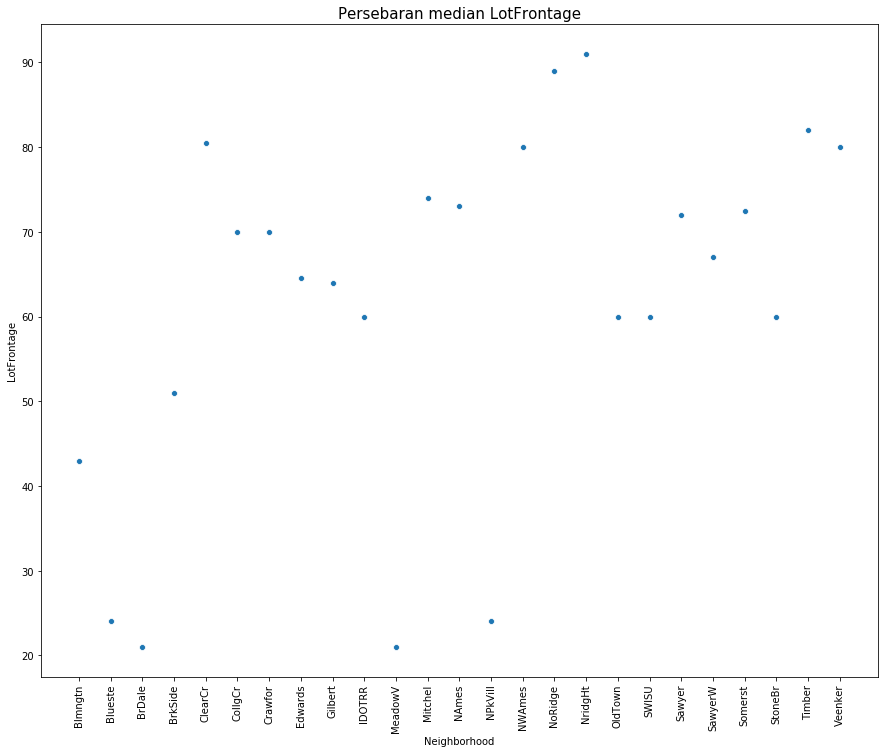

In [35]:
neighborhood_group = all_features.groupby('Neighborhood')
lot_medians = neighborhood_group['LotFrontage'].median()

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.scatterplot(lot_medians.keys(),lot_medians[:])
plt.title('Persebaran median LotFrontage', fontsize=15)

In [0]:
all_features['LotFrontage'] = all_features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [37]:
#Filling in the rest of the NA's

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in all_features.columns:
    if (all_features[i].dtype in numeric_dtypes): 
        numerics.append(i)
        
all_features.update(all_features[numerics].fillna(0))

nas = np.sum(all_features.isnull())
nascols = nas.loc[(nas != 0)]
dtypes = all_features.dtypes
dtypes2 = dtypes.loc[(nas != 0)]
info = pd.concat([nascols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nascols), "columns with missing values")

Empty DataFrame
Columns: [0, 1]
Index: []
There are 0 columns with missing values


In [38]:
all_features.describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,GarageCars,GarageYrBlt,GrLivArea,HalfBath,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MasVnrArea,MiscVal,OpenPorchSF,OverallCond,OverallQual,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
count,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000
mean,1157.002060,336.322691,2.607621,2.860625,438.508067,49.667353,0.428768,0.061449,560.082733,23.145898,0.595949,1.567456,471.311363,0.883968,1871.455887,1498.028836,0.380021,1.044628,10126.595949,69.391006,4.704085,100.633711,50.738414,47.291795,5.566426,6.086165,2.091658,16.095434,6.447305,1048.258153,93.542739,1971.279094,1984.246481
std,384.669826,428.232473,25.213828,0.823215,443.581695,169.338330,0.523969,0.245845,439.007628,64.301832,0.644991,0.552528,212.481322,1.039862,447.441358,496.897683,0.502848,0.214673,7799.442086,21.178116,46.444109,177.608263,567.904167,67.152749,1.113324,1.403656,34.585013,56.237482,1.565002,428.922838,126.421729,30.284855,20.886591
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,1300.000000,21.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1872.000000,1950.000000
25%,876.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,220.000000,0.000000,0.000000,1.000000,320.000000,0.000000,1957.000000,1126.000000,0.000000,1.000000,7472.000000,60.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,0.000000,0.000000,5.000000,792.000000,0.000000,1953.000000,1965.000000
50%,1082.000000,0.000000,0.000000,3.000000,368.000000,0.000000,0.000000,0.000000,467.000000,0.000000,1.000000,2.000000,479.000000,0.000000,1977.000000,1442.000000,0.000000,1.000000,9450.000000,70.000000,0.000000,0.000000,0.000000,26.000000,5.000000,6.000000,0.000000,0.000000,6.000000,988.000000,0.000000,1973.000000,1993.000000
75%,1383.000000,704.000000,0.000000,3.000000,732.000000,0.000000,1.000000,0.000000,803.000000,0.000000,1.000000,2.000000,576.000000,2.000000,2001.000000,1743.000000,1.000000,1.000000,11526.000000,80.000000,0.000000,162.000000,0.000000,70.000000,6.000000,7.000000,0.000000,0.000000,7.000000,1300.000000,168.000000,2001.000000,2004.000000
max,5095.000000,2065.000000,508.000000,8.000000,4010.000000,1526.000000,3.000000,2.000000,2336.000000,1012.000000,4.000000,4.000000,1488.000000,5.000000,2207.000000,5095.000000,2.000000,3.000000,215245.000000,313.000000,1064.000000,1600.000000,17000.000000,742.000000,9.000000,10.000000,800.000000,576.000000,15.000000,5095.000000,1424.000000,2010.000000,2010.000000


In [0]:
all_features.loc[all_features['GarageYrBlt'] , 'GarageYrBlt'] = 2007

In [40]:
all_features.select_dtypes('object').describe().T

,count,unique,top,freq
Alley,2913,3,None,2715
BldgType,2913,5,1Fam,2420
BsmtCond,2913,5,TA,2600
BsmtExposure,2913,5,No,1903
BsmtFinType1,2913,7,Unf,849
BsmtFinType2,2913,7,Unf,2487
BsmtQual,2913,6,TA,1281
CentralAir,2913,2,Y,2717
Condition1,2913,9,Norm,2508
Condition2,2913,8,Norm,2885


In [0]:
all_features.drop(['Utilities','Street'],axis=1,inplace=True)

# Feature Engineering

In [0]:
all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
                                 all_features['1stFlrSF'] + all_features['2ndFlrSF'])

all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5*all_features['HalfBath']) + 
                               all_features['BsmtFullBath'] + (0.5*all_features['BsmtHalfBath']))

all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                             all_features['WoodDeckSF'])


#simplified features
all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['has2ndfloor'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

all_features = pd.get_dummies(all_features).reset_index(drop=True)

In [0]:
#log transform skewed numeric features:
numeric_feats = all_features.dtypes[all_features.dtypes != "object"].index

skewed_feats = all_features[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_features[skewed_feats] = np.log1p(all_features[skewed_feats])

In [44]:
all_features.shape


(2913, 337)

In [45]:
labels.shape

(1454,)

In [46]:
X = all_features.iloc[:len(labels),:]
testing_features = all_features.iloc[len(X):,:]

print(X.shape)
print(testing_features.shape)

(1454, 337)
(1459, 337)


# Model

In [47]:
X.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,GarageCars,GarageYrBlt,GrLivArea,HalfBath,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MasVnrArea,MiscVal,OpenPorchSF,OverallCond,OverallQual,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,Alley_Grvl,Alley_None,Alley_Pave,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_Po,BsmtQual_TA,CentralAir_N,CentralAir_Y,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_None,MSZoning_RH,MSZoning_RL,MSZoning_RM,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,

In [48]:
labels.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,labels,test_size=0.25, random_state=42)

## RIDGE

In [50]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.2028 (0.0189)



## LASSO

In [51]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso score: 0.1104 (0.0075)



## Elastic Net

In [52]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1103 (0.0074)



## Gradient Boost

In [54]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1156 (0.0086)



## Final Model

In [0]:
LassoMd = lasso.fit(X,labels)
ENetMd = ENet.fit(X,labels)
KRRMd = KRR.fit(X,labels)
GBoostMd = GBoost.fit(X,labels)

In [56]:
finalMd = (np.expm1(LassoMd.predict(testing_features)) + np.expm1(ENetMd.predict(testing_features)) ) / 2
finalMd

array([124605.85509382, 158276.56361609, 184480.23455058, ...,
       170384.23702801, 118180.11292856, 224651.36034996])

In [0]:
EnetPD = np.expm1(ENetMd.predict(testing_features))

In [63]:
df_submit = pd.read_csv('sample_submission.csv')
df_submit['SalePrice'] = finalMd
df_submit.to_csv('submission_all.csv', index=False) 
print('Final file made\n')

Final file made

